In [1]:
import socket

NB='test2'
DESCRIPTION='test notebook'
HOST = socket.gethostname()
HOST, NB

('c20bcc15152c', 'test2')

In [2]:
!nvidia-smi

Sat Mar  4 16:04:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0  On |                  N/A |
| 61%   62C    P2   119W / 350W |   1864MiB / 24576MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import transformers
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, KFold
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
import numpy as np
import re
from pathlib import Path
import pickle
from transformers import AutoTokenizer, AutoConfig
import random
from logzero import logger
import os
import gc
import warnings
warnings.simplefilter('ignore')

ROOT_DIR = Path('../')
DATA_DIR = ROOT_DIR / 'data'
OUTPUT_DIR = Path('../') / 'output'
CP_DIR = OUTPUT_DIR / 'checkpoint'

def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def unpickle(filename):
    with open(filename, mode='rb') as fo:
        p = pickle.load(fo)
    return p 

In [4]:
import multiprocessing
print('cpu count:', multiprocessing.cpu_count())

class Config:
    N_LABEL = 1
    N_FOLD = 5
    RANDOM_SATE = 42
    LR = 1.0e-05
    MAX_LR = 3.0e-5
    PATIENCE = 10
    EPOCH = 3
    BATCH_SIZE = 128
    SKIP_EVALUATE_NUM = 0
    MODEL_NAME = 'huggingface/CodeBERTa-small-v1'
    RUN_FOLD_COUNT = 10
    T_MAX=20
    ETA_MIN=3.0e-7
    SCHEDULER_GAMMA=1.0
    ACCUMULATION_STEMP=2
    NUM_WORKERS=multiprocessing.cpu_count()
    
    MAX_LEN = 256
    
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=Config.RANDOM_SATE)

cpu count: 32


In [5]:
train_df = pd.read_csv(DATA_DIR / 'tweet_train.csv')
#_train_df = train_df[['code', 'label']]
#_train_df.columns = ['text', 'target']

test_df = pd.read_csv(DATA_DIR / 'tweet_test.csv')
#_test_df = test_df[['code']]
#_test_df.columns = ['text']

display(train_df.shape)
display(test_df.shape)

display(train_df.head(3))
display(test_df.head(3))

(7613, 5)

(3263, 4)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    Config.MODEL_NAME,
    do_lower_case=True,
    truncation=True
)

In [7]:
class BERTDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, data_type='train'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data_type = data_type
        
    def __getitem__(self, index):
        txt = str(self.data.text[index])
        inputs = self.tokenizer.encode_plus(
            txt,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        if self.data_type == 'test':
            targets = -1
        else:
            targets = torch.tensor(self.data.target[index], dtype=torch.float)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': targets
        }
        
    def __len__(self):
        return len(self.data)

In [8]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.config = AutoConfig.from_pretrained(Config.MODEL_NAME)
        self.bert = transformers.AutoModel.from_pretrained(Config.MODEL_NAME)
        self.drop = torch.nn.Dropout(0.3)
        self.out = torch.nn.Linear(self.config.hidden_size, 1)
    
    def forward(self, ids, mask):
        distilbert_output = self.bert(ids, mask)
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        output_1 = self.drop(pooled_output)
        output = self.out(output_1)
        return output

In [9]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, fold=''):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            logger.info(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            logger.info(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            
        #if os.path.exists(CP_DIR / f'checkpoint_{NB}_{fold}.pt'):
        #    shutil.move(CP_DIR / f'checkpoint_{NB}_{fold}.pt', CP_DIR / f'checkpoint_{NB}_{fold}-2.pt')
        torch.save(model.state_dict(), CP_DIR / f'{HOST}_{NB}_checkpoint_{fold}.pt')
        self.val_loss_min = val_loss

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

====== 0 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 47/47 [00:22<00:00,  2.05it/s, epoch=0, loss=0.6233]
100% 12/12 [00:02<00:00,  5.34it/s]
[I 230304 16:04:58 <timed exec>:80] auc:0.7719
[I 230304 16:04:58 3624789395:31] Validation loss decreased (inf --> -0.771944).  Saving model ...
100% 47/47 [00:

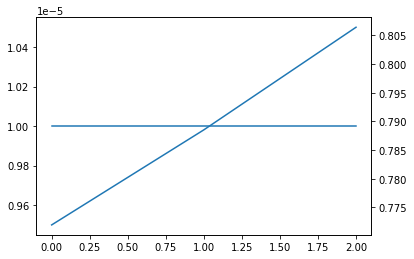

====== 1 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 47/47 [00:23<00:00,  2.03it/s, epoch=0, loss=0.6901]
100% 12/12 [00:02<00:00,  5.50it/s]
[I 230304 16:06:31 <timed exec>:80] auc:0.7662
[I 230304 16:06:31 3624789395:31] Validation loss decreased (inf --> -0.766220).  Saving model ...
100% 47/47 [00:

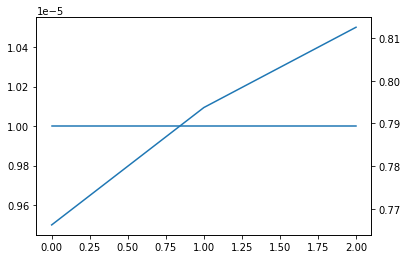

====== 2 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 47/47 [00:22<00:00,  2.08it/s, epoch=0, loss=0.5454]
100% 12/12 [00:02<00:00,  5.78it/s]
[I 230304 16:08:02 <timed exec>:80] auc:0.7558
[I 230304 16:08:02 3624789395:31] Validation loss decreased (inf --> -0.755777).  Saving model ...
100% 47/47 [00:

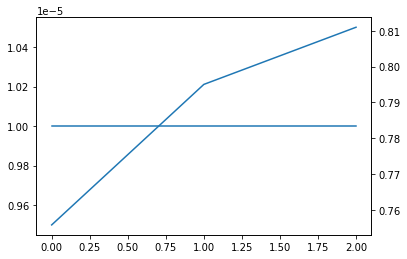

====== 3 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 47/47 [00:22<00:00,  2.11it/s, epoch=0, loss=0.6012]
100% 12/12 [00:02<00:00,  5.88it/s]
[I 230304 16:09:31 <timed exec>:80] auc:0.7529
[I 230304 16:09:31 3624789395:31] Validation loss decreased (inf --> -0.752937).  Saving model ...
100% 47/47 [00:

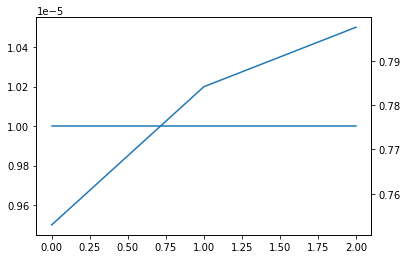

====== 4 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 47/47 [00:22<00:00,  2.11it/s, epoch=0, loss=0.6971]
100% 12/12 [00:02<00:00,  5.91it/s]
[I 230304 16:11:00 <timed exec>:80] auc:0.7617
[I 230304 16:11:00 3624789395:31] Validation loss decreased (inf --> -0.761666).  Saving model ...
100% 47/47 [00:

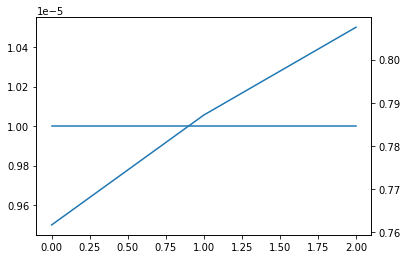

CPU times: user 6min 19s, sys: 1min 12s, total: 7min 31s
Wall time: 7min 32s


In [11]:
%%time
skf = StratifiedKFold(n_splits=Config.N_FOLD, random_state=Config.RANDOM_SATE, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df['target'])):
    print(f'====== {fold} ======')

    net = BERTClass()
    net.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(net.parameters(), lr=Config.LR, weight_decay=1.0e-02)    

    _train, _valid = train_df.iloc[train_index].reset_index(drop=True), train_df.iloc[test_index].reset_index(drop=True)

    training_set = BERTDataset(_train, tokenizer, Config.MAX_LEN, data_type='train')
    validation_set = BERTDataset(_valid, tokenizer, Config.MAX_LEN, data_type='valid')

    trainloader = DataLoader(training_set, batch_size=Config.BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=Config.NUM_WORKERS)
    validloader = DataLoader(validation_set, batch_size=Config.BATCH_SIZE, pin_memory=True, num_workers=Config.NUM_WORKERS)

    early_stopping = EarlyStopping(patience=Config.PATIENCE, verbose=True, fold=fold)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=Config.EPOCH, steps_per_epoch=len(trainloader), max_lr=Config.MAX_LR, pct_start= 0.1, anneal_strategy='cos', div_factor= 1.0e+3, final_div_factor= 1.0e+3)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.T_MAX, eta_min=Config.ETA_MIN)
    # scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=int((len(trainloader) * Config.EPOCH) / 5), cycle_mult=1.0, max_lr=Config.LR, min_lr=Config.ETA_MIN, warmup_steps=int((len(trainloader) * Config.EPOCH) / 50), gamma=Config.SCHEDULER_GAMMA)

    val_losses = []
    val_metrics = []
    train_metrics = []
    lrs = []

    for epoch in range(Config.EPOCH):

        running_loss = 0.0
        train_rmse_list = []
        n_iter = len(trainloader)
        with tqdm(enumerate(trainloader), total=n_iter) as pbar:
            for i, (data) in pbar:

                net.train()

                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)


                outputs = outputs = net(ids, mask).squeeze()

                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()
                net.zero_grad()     

                # print statistics
                running_loss += loss.item()

                outputs = outputs.sigmoid()

                pbar.set_postfix(OrderedDict(
                    epoch="{:>10}".format(epoch), loss="{:.4f}".format(loss.item())#, auc='{:.4f}'.format(auc)
                ))
                #scheduler.step()

        val_loss = 0.0
        val_lwlrap = 0.0
        val_preds = []
        n_iter_val = len(validloader)
        for i, (data) in tqdm(enumerate(validloader), total=n_iter_val):
            net.eval()

            with torch.no_grad():

                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = outputs = net(ids, mask).squeeze()
                outputs_np = outputs.to('cpu').detach().numpy().copy()
                val_preds.append(outputs_np)


        auc = roc_auc_score(_valid['target'], np.hstack(val_preds))
        logger.info('auc:{:.4f}'.format(auc))

        lr = optimizer.param_groups[0]['lr']

        val_metrics.append(auc)
        train_metrics.append(np.mean(train_rmse_list))
        lrs.append(lr)

        early_stopping(-auc, net)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            #net.load_state_dict(torch.load(CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt'))
            break

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(lrs)
    ax2 = ax1.twinx()
    ax2.plot(val_metrics)
    plt.show()

    del net, validloader, trainloader, training_set, validation_set
    torch.cuda.empty_cache()
    gc.collect()


In [16]:
%%time
cv_scores = {}
oof = np.zeros(len(train_df))
skf = StratifiedKFold(n_splits=Config.N_FOLD, random_state=Config.RANDOM_SATE, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df['target'])):
    print(f'====== {fold} ======')

    net = BERTClass()
    net.to(device)

    _train, _valid = train_df.iloc[train_index].reset_index(drop=True), train_df.iloc[test_index].reset_index(drop=True)
    validation_set = BERTDataset(_valid, tokenizer, Config.MAX_LEN, data_type='valid')
    validloader = DataLoader(validation_set, batch_size=Config.BATCH_SIZE, pin_memory=True, num_workers=Config.NUM_WORKERS)

    preds = []
    n_iter_val = len(validloader)
    for i, (data) in tqdm(enumerate(validloader), total=n_iter_val):
        net.load_state_dict(torch.load(CP_DIR / f'{HOST}_{NB}_checkpoint_{fold}.pt'))
        net.eval()
        
        with torch.no_grad():

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = outputs = net(ids, mask).squeeze()
            outputs_np = outputs.to('cpu').detach().numpy().copy()
            preds.append(outputs_np)


    auc = roc_auc_score(_valid['target'], np.hstack(preds))
    print(auc)

    oof[test_index] = np.hstack(preds).reshape(-1)
    cv_scores[f'cv{fold}'] = auc

    del net, validation_set, validloader
    torch.cuda.empty_cache()
    gc.collect()


====== 0 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 12/12 [00:03<00:00,  3.47it/s]


0.8064305062088859
====== 1 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 12/12 [00:03<00:00,  3.50it/s]


0.8125195750326396
====== 2 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 12/12 [00:03<00:00,  3.52it/s]


0.8109720477331672
====== 3 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 12/12 [00:03<00:00,  3.52it/s]


0.79761464366747
====== 4 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 12/12 [00:03<00:00,  3.53it/s]


0.8074865415239787
CPU times: user 17 s, sys: 15.9 s, total: 33 s
Wall time: 41.7 s


In [17]:
roc_auc_score(train_df['target'], oof)

0.8048955471931287

In [18]:
y_preds = np.zeros(len(test_df))

test_set = BERTDataset(test_df, tokenizer, Config.MAX_LEN, data_type='test')
testloader = DataLoader(test_set, batch_size=Config.BATCH_SIZE, pin_memory=True, num_workers=Config.NUM_WORKERS)

nets = []
for fold in range(Config.N_FOLD):
    net = BERTClass()
    net.to(device)
    net.load_state_dict(torch.load(CP_DIR / f'{HOST}_{NB}_checkpoint_{fold}.pt'))
    nets.append(net)

fold_preds = []
for i, (data) in tqdm(enumerate(testloader), total=len(testloader)):
    net.eval()
    with torch.no_grad():

        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        
        
        outputs_nps = []
        for net in nets:
            outputs = net(ids, mask).squeeze()
            outputs_np_fold = outputs.to('cpu').detach().numpy().copy()
            outputs_nps.append(outputs_np_fold)

        fold_preds.append(np.mean(outputs_nps, axis=0))

y_preds = np.hstack(fold_preds).reshape(-1)

Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weigh

In [19]:
test_df['label'] = np.hstack(y_preds)
test_df[['id', 'label']].to_csv(OUTPUT_DIR / f'sub_{HOST}_{NB}.csv', index=False)

(array([ 19., 193., 549., 711., 632., 444., 349., 236., 106.,  24.]),
 array([-4.3425126 , -3.4780247 , -2.613537  , -1.7490492 , -0.8845614 ,
        -0.02007365,  0.8444141 ,  1.7089019 ,  2.5733898 ,  3.4378774 ,
         4.3023653 ], dtype=float32),
 <BarContainer object of 10 artists>)

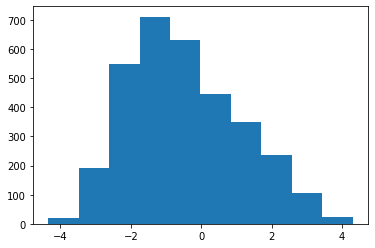

In [22]:
plt.hist(y_preds)